# Imports

## Packages

In [33]:
import zipfile
import os

In [34]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy import stats

## Data

In [35]:
zip_path = "Apple Stock Prices From 1981 to 2023.zip"
extract_dir = "unzipped_files"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Files extracted to: {extract_dir}")

Files extracted to: unzipped_files


In [36]:

df = pd.read_csv("unzipped_files/Apple Stock Prices (1981 to 2023).csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/1981,0.154018,0.155134,0.154018,0.154018,0.119849,21660800
1,05/01/1981,0.151228,0.151228,0.150670,0.150670,0.117244,35728000
2,06/01/1981,0.144531,0.144531,0.143973,0.143973,0.112032,45158400
3,07/01/1981,0.138393,0.138393,0.137835,0.137835,0.107256,55686400
4,08/01/1981,0.135603,0.135603,0.135045,0.135045,0.105085,39827200


# EDA

## Basic Description

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10608 entries, 0 to 10607
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10608 non-null  object 
 1   Open       10608 non-null  float64
 2   High       10608 non-null  float64
 3   Low        10608 non-null  float64
 4   Close      10608 non-null  float64
 5   Adj Close  10608 non-null  float64
 6   Volume     10608 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 580.3+ KB


In [38]:
print("Duplicate rows:", df.duplicated().sum()) # Check for duplicates
print("\nMissing values per column:")
print(df.isnull().sum()) #handle missing values

Duplicate rows: 0

Missing values per column:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## Convert date columns to datetime

In [39]:
date_column = ['Date']
df['Date'] = pd.to_datetime(df['Date'],format ="%d/%m/%Y", errors ="coerce")
print("Data types after conversion:")
print(df['Date'].dtypes)



Data types after conversion:
datetime64[ns]


In [40]:
print("First date:", df["Date"].min().date())
print("Last date :", df["Date"].max().date())
print("Row count :", len(df))
print("Unique dates:", df["Date"].nunique())
print("Has duplicate dates?", df["Date"].nunique() < len(df))

First date: 1981-01-02
Last date : 2023-01-27
Row count : 10608
Unique dates: 10608
Has duplicate dates? False


## Time Series Properties

### Initial Plot

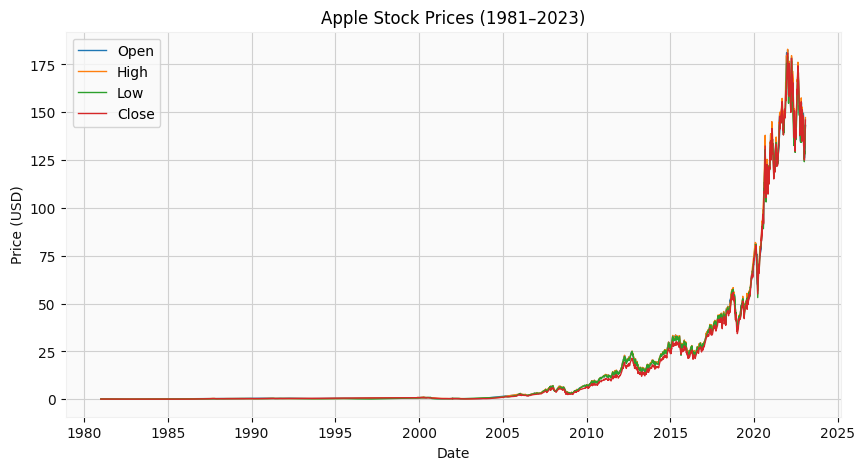

In [41]:
# Plot Open, High, Low, Close
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Open"], label="Open", linewidth=1)
plt.plot(df["Date"], df["High"], label="High", linewidth=1)
plt.plot(df["Date"], df["Low"], label="Low", linewidth=1)
plt.plot(df["Date"], df["Adj Close"], label="Close", linewidth=1)

plt.title("Apple Stock Prices (1981–2023)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


The values are too close to each other to see the difference. Let's focus on the adj. close and visualize the trend

### Trend

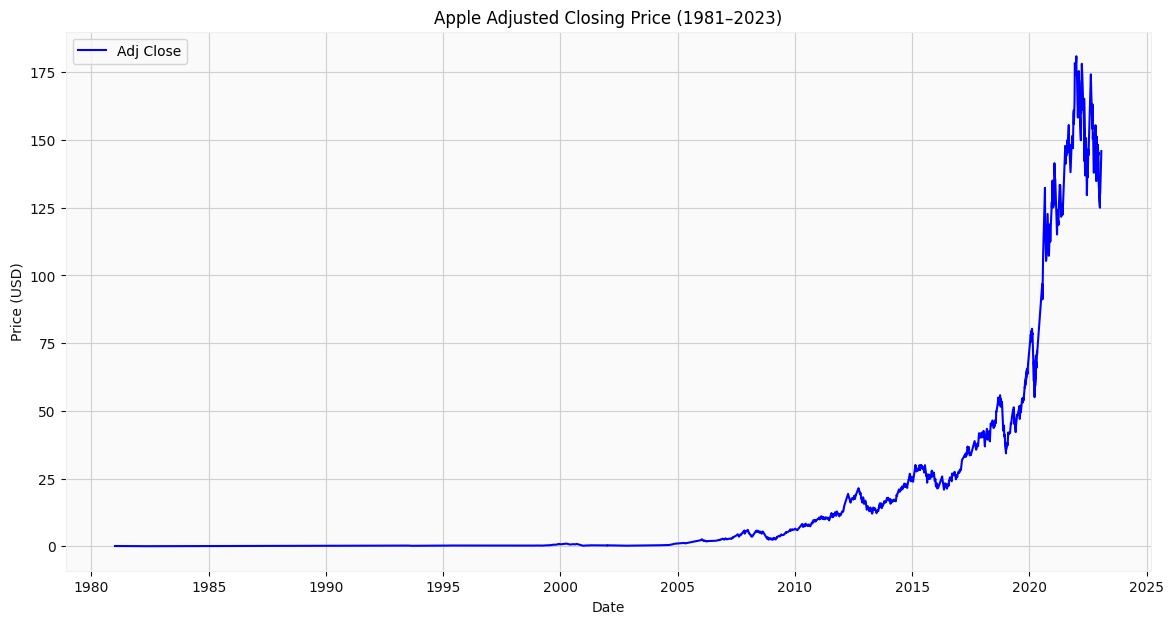

In [42]:
plt.figure(figsize=(14,7))
plt.plot(df["Date"], df["Adj Close"], label="Adj Close", color="blue")
plt.title("Apple Adjusted Closing Price (1981–2023)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


We observe 3 main phases during the whole period:
- <b>1980 - 2000:</b> Little to no increse in stock prices
- <b>2000 - 2008:</b> Small stock's price growth (Steve Jobs joins back, release the first ipod, but 2008 subprime crisis)
- <b>2008 - 2019:</b> Exponential increase in stock prices (release of first iphone, solid market loyalty...)
- <b>2019 - 2021:</b> Huge spike in stocks( COVID-19 demand for electronics)
- <b>2022 - 2023:</b> Sharp decline in stock prices (global supply chain crisis)

### Frequency

#### Naive Frequency

In [43]:
ts = df.set_index("Date", drop=False).sort_index()
print("Inferred freq:", pd.infer_freq(ts.index))


Inferred freq: None


### Weekday Frequency

In [44]:

deltas = ts.index.to_series().diff().dropna()
print("\nMost common step (mode):", deltas.mode().iloc[0])
print("Median step             :", deltas.median())
print("Share of 1 business-day steps:",
      (deltas == pd.Timedelta(days=1)).mean().round(3),
      " (note: calendar days, not trading)")



Most common step (mode): 1 days 00:00:00
Median step             : 1 days 00:00:00
Share of 1 business-day steps: 0.784  (note: calendar days, not trading)


Most of the dates (78.4%) in the dataset are 1 calendar day apart (21.6 % are weekends and holidays).This is a normal pattern for stock market data. Let's verify it

In [45]:
bidx = pd.bdate_range(start=ts.index.min(), end=ts.index.max(), freq="D")
aligned = ts.reindex(bidx)
missing_mask = aligned.index.difference(ts.index)
print("\nApprox. missing days count:", len(missing_mask))



Approx. missing days count: 4758


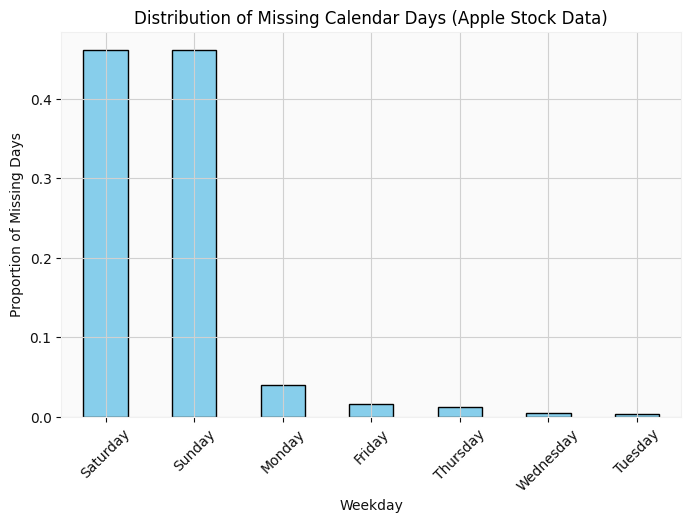

In [46]:

missing_weekdays = missing_mask.day_name()

weekday_counts = missing_weekdays.value_counts(normalize=True)

# Plot
plt.figure(figsize=(8,5))
weekday_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Distribution of Missing Calendar Days (Apple Stock Data)")
plt.ylabel("Proportion of Missing Days")
plt.xlabel("Weekday")
plt.xticks(rotation=45)
plt.show()


We confirmed that the missing days are indeed weekends and the other ones must be holidays.

### Yearly trading days frequency

In [47]:
by_year_counts = ts.resample("YE").size()
print("\nObserved trading days per year:")
print(by_year_counts.tail(10))


Observed trading days per year:
Date
2014-12-31    252
2015-12-31    252
2016-12-31    252
2017-12-31    251
2018-12-31    251
2019-12-31    252
2020-12-31    253
2021-12-31    252
2022-12-31    251
2023-12-31     18
Freq: YE-DEC, dtype: int64


We can observe that each year has approx 252 trading days except 2023 due to the data ending on 2023-01-27.It must represent 18 trading days.

### Daily Returns

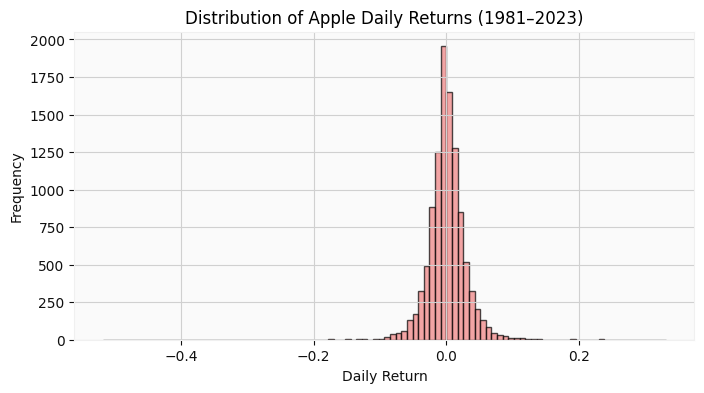

Min daily return: -0.52
Max daily return: 0.33


In [48]:
df["Daily Return"] = df["Adj Close"].pct_change()
plt.figure(figsize=(8,4))
plt.hist(df["Daily Return"].dropna(), bins=100, color="lightcoral", edgecolor="black", alpha=0.7)

plt.title("Distribution of Apple Daily Returns (1981–2023)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()


print("Min daily return:", df["Daily Return"].min().round(2))
print("Max daily return:", df["Daily Return"].max().round(2))


- The distribution of data is centered around 0 -> most of the days Apple's stock barely moves up or down.
- It typically moves within -2% / +2% per day.
- Rare we can observe some significant outliers (e.g min or max daily return)

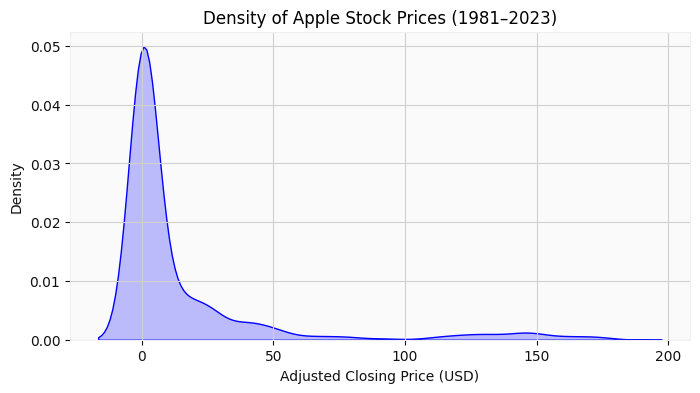

In [49]:
import seaborn as sns

plt.figure(figsize=(8,4))
sns.kdeplot(df["Adj Close"], fill=True, color="blue")

plt.title("Density of Apple Stock Prices (1981–2023)")
plt.xlabel("Adjusted Closing Price (USD)")
plt.ylabel("Density")
plt.show()


Plot shows that Apple’s stock has historically spent most of its life at low valuations, with the very high prices being a more recent phenomenon.

# Data Visualization

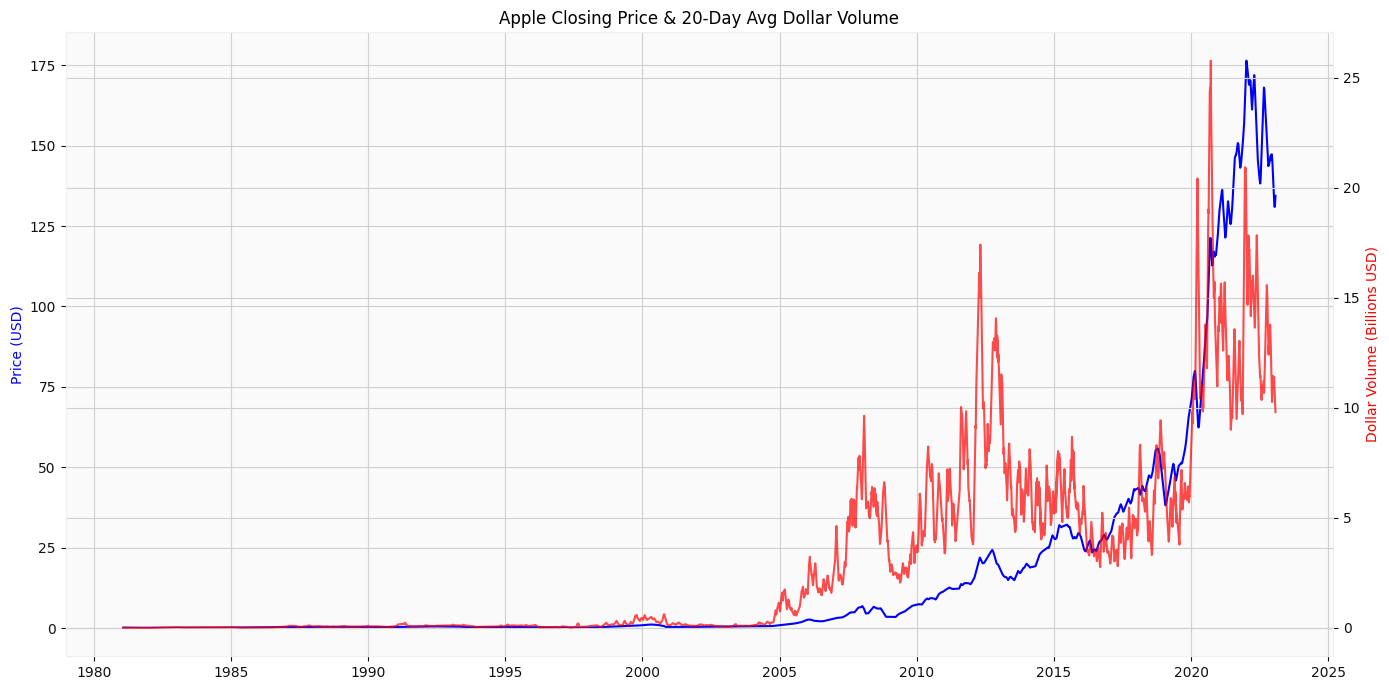

In [50]:
# 20-day rolling averages
df["Close_20D"] = df["Close"].rolling(20).mean()
df["DollarVolume_20D"] = (df["Close"] * df["Volume"]).rolling(20).mean()


fig, ax1 = plt.subplots(figsize=(14,7))

# Plot smoothed closing price
ax1.plot(df["Date"], df["Close_20D"], color="blue", label="20D Close (USD)")
ax1.set_ylabel("Price (USD)", color="blue")

# Plot smoothed dollar volume (billions)
ax2 = ax1.twinx()
ax2.plot(df["Date"], df["DollarVolume_20D"]/1e9, color="red", alpha=0.7, label="20D Dollar Volume")
ax2.set_ylabel("Dollar Volume (Billions USD)", color="red")

plt.title("Apple Closing Price & 20-Day Avg Dollar Volume")
fig.tight_layout()

plt.show()


- Apple’s closing price stayed relatively flat until the mid-2000s, after which it grew dramatically (release of ipod,iphone)
- Dollar trading volume increased significantly over time showing rising investor interest
- Spikes in dolar volume corresponds to major events: Financial crisis (2008), prduct launchea and COVID-19
- Between 2018-2022 both price and dollar volume reached records highs -> Apple transformed to one of the most traded and valuable companies.

### Candlestick charts

### Daily - Last 6 months

/var/folders/zs/lhn3v0dx0v32gt7hm_r0m1zc0000gn/T/ipykernel_53037/61213500.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  mpf.plot(dfc.last('180D'), type='candle', volume=True, style='yahoo',


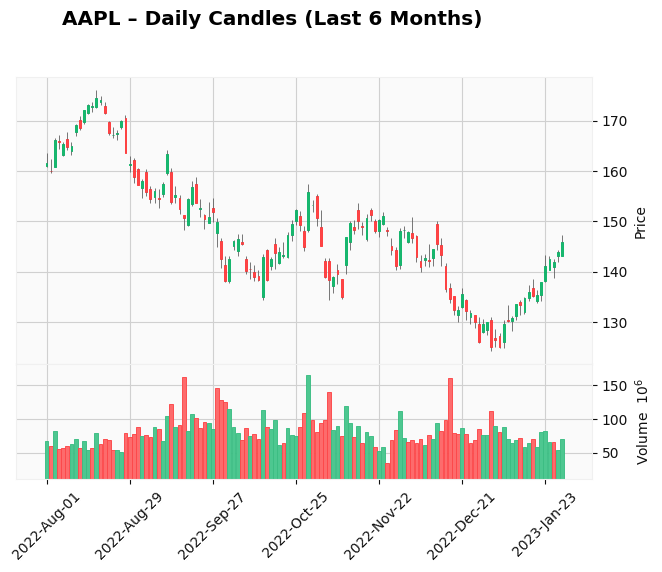

In [51]:
import mplfinance as mpf
dfc = df.set_index(pd.to_datetime(df['Date'])).sort_index()
mpf.plot(dfc.last('180D'), type='candle', volume=True, style='yahoo',
         title='AAPL – Daily Candles (Last 6 Months)')


- Overall trend: Apple’s stock declined from around $170 in August 2022 to a low near $125 in December 2022, before rebounding into early 2023 (~$145).

### Monthly (2015 - Present)

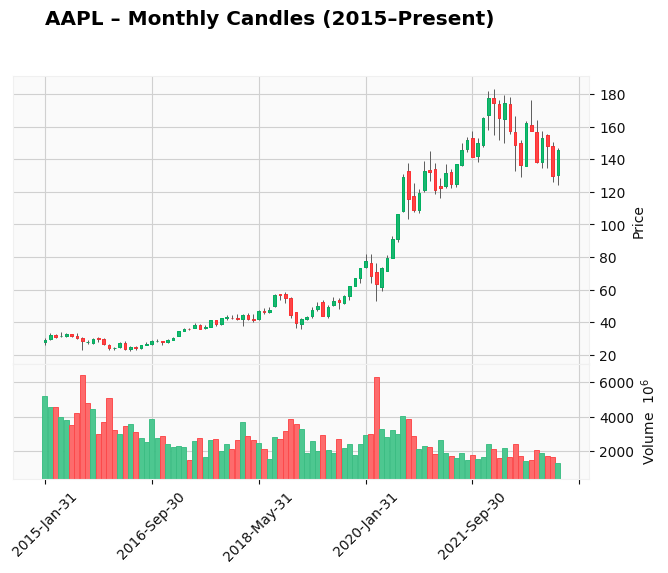

In [52]:
mo = dfc.resample('ME').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})
mpf.plot(mo.loc['2015':], type='candle', volume=True, style='yahoo',
         title='AAPL – Monthly Candles (2015–Present)')


- 2015–2018: Apple traded relatively flat, mostly between $20–$60. Growth was steady but not explosive.

- 2019–2020: Beginning of a strong uptrend. Prices broke above $60 and accelerated upward.

- 2020–2021: Apple stock prices increased from around $60 to above $180, driven by strong earnings, product cycles (iPhone 12, services growth), and market liquidity during COVID.

- 2022–Present: After peaking near $180, Apple entered a declining phase, retracing toward $140–$150. This aligns with global market weakness, inflation, and tech-sector sell-offs.

# Statistical Analysis

### Summary statistics

In [53]:
summary_stats = ts[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].agg(
    ["mean", "median", "std"]).T  # transpose for readability

# Round to 2 decimals for prices, convert Volume to millions
summary_stats = summary_stats.round(2)
summary_stats.loc["Volume", ["mean", "median", "std"]] = (
    summary_stats.loc["Volume"] / 1e6
).round(2)

# Rename Volume row for clarity
summary_stats.rename(index={"Volume": "Volume (M)"}, inplace=True)

print(summary_stats)

              mean  median     std
Open         16.69    0.49   35.45
High         16.88    0.50   35.88
Low          16.50    0.48   35.03
Close        16.70    0.49   35.47
Adj Close    16.03    0.40   35.15
Volume (M)  327.51  214.60  337.82


Prices (open,high,low,close):
- The mean is around 16–17, while the median is near 0.5.

- This huge gap tells us that data contains very small values (likely recent post-split prices) and much larger historical values, so the distribution is heavily skewed.

- The standard deviation (~35) is more than double the mean -> confirms very high variability across the dataset.

Volume :
- Mean ~ 328M, median ~ 215M, std ~ 338M.
- Trading activity varies a lot day to day. Sometimes Apple trades at relatively low levels (~200M shares), other times much higher, hence the large std.

### Moving average (closing price)

In [54]:
#  Moving Averages
df["SMA_20"]  = df['Close'].rolling(window=20,  min_periods=1).mean()
df["SMA_50"]  = df['Close'].rolling(window=50,  min_periods=1).mean()
df["SMA_200"] = df['Close'].rolling(window=200, min_periods=1).mean()

df[[ "Date", "Close", "SMA_20", "SMA_50", "SMA_200" ]].tail()


,Date,Close,SMA_20,SMA_50,SMA_200
10603,2023-01-23,141.110001,131.685499,139.215399,148.81830
10604,2023-01-24,142.529999,132.200500,139.368599,148.67180
10605,2023-01-25,141.860001,132.700500,139.268399,148.52040
10606,2023-01-26,143.960007,133.397000,139.153600,148.38975
10607,2023-01-27,145.929993,134.391499,139.106599,148.29065


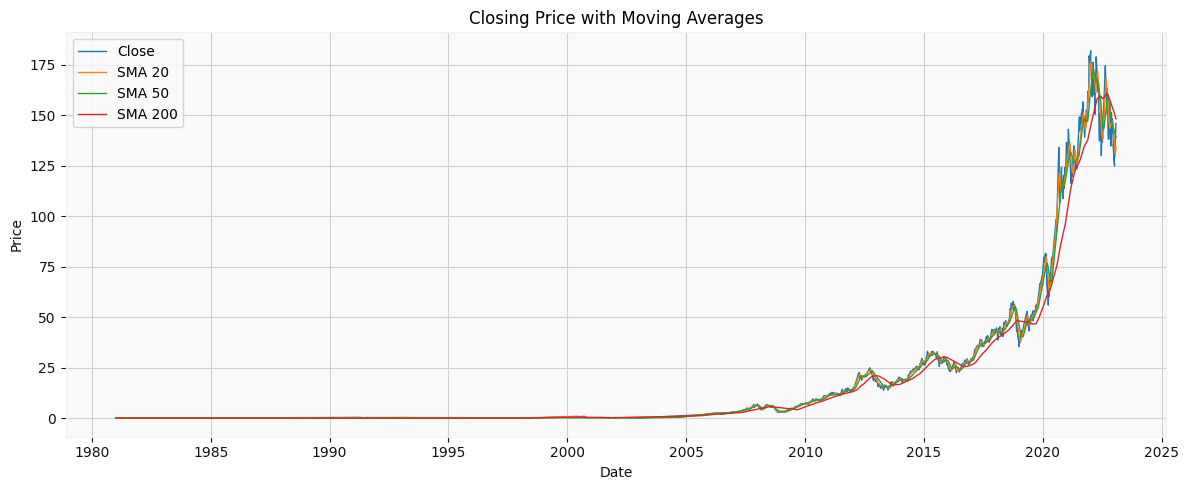

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df['Close'], label="Close", linewidth=1)
plt.plot(df["Date"], df["SMA_20"],  label="SMA 20",  linewidth=1)
plt.plot(df["Date"], df["SMA_50"],  label="SMA 50",  linewidth=1)
plt.plot(df["Date"], df["SMA_200"], label="SMA 200", linewidth=1)
plt.title("Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


# Hypothesis Testing

In [62]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,Close_20D,DollarVolume_20D,SMA_20,SMA_50,SMA_200,Year
0,1981-01-02,0.154018,0.155134,0.154018,0.154018,0.119849,21660800,NaN,NaN,NaN,0.154018,0.154018,0.154018,1981
1,1981-01-05,0.151228,0.151228,0.150670,0.150670,0.117244,35728000,-0.021736,NaN,NaN,0.152344,0.152344,0.152344,1981
2,1981-01-06,0.144531,0.144531,0.143973,0.143973,0.112032,45158400,-0.044454,NaN,NaN,0.149554,0.149554,0.149554,1981
3,1981-01-07,0.138393,0.138393,0.137835,0.137835,0.107256,55686400,-0.042631,NaN,NaN,0.146624,0.146624,0.146624,1981
4,1981-01-08,0.135603,0.135603,0.135045,0.135045,0.105085,39827200,-0.020241,NaN,NaN,0.144308,0.144308,0.144308,1981


In [67]:
df["Year"] = df["Date"].dt.year


### Two-sample t-test: compare average closing prices between two years

We’ll use Welch’s t-test (safer when variances differ).
Hypotheses

H₀: mean close (Year A) = mean close (Year B)

H₁: means are different

In [70]:
def ttest_two_years(df, year_a, year_b, col):
    a = df.loc[df["Year"] == year_a, col].to_numpy()
    b = df.loc[df["Year"] == year_b, col].to_numpy()

    # Basic checks
    if len(a) < 2 or len(b) < 2:
        raise ValueError("Not enough daily prices in one of the years.")

    # Welch t-test
    t_stat, p_val = stats.ttest_ind(a, b, equal_var=False)

    # Effect size (Cohen's d using pooled SD with unequal sizes)
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    n1, n2 = len(a), len(b)
    s_pooled = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    cohen_d = (a.mean() - b.mean()) / s_pooled

    print(f"Comparing mean {col} in {year_a} vs {year_b}")
    print(f"n_a={n1}, mean_a={a.mean():.2f}, sd_a={s1:.2f}")
    print(f"n_b={n2}, mean_b={b.mean():.2f}, sd_b={s2:.2f}")
    print(f"Welch t = {t_stat:.3f}, p = {p_val:.3g}")
    print(f"Effect size (Cohen's d) = {cohen_d:.2f}")
    if p_val < 0.05:
        print("Conclusion: Means differ (reject H0 at 5%).")
    else:
        print("Conclusion: No evidence of a difference (fail to reject H0).")

# EXAMPLE: change to years you want
ttest_two_years(df, 2019, 2020, "Close")


Comparing mean Close in 2019 vs 2020
n_a=252, mean_a=52.06, sd_a=8.63
n_b=253, mean_b=95.35, sd_b=21.81
Welch t = -29.342, p = 6.64e-94
Effect size (Cohen's d) = -2.61
Conclusion: Means differ (reject H0 at 5%).


### Conclusion:
I compared the average daily closing prices for 2019 and 2020.
- The test gave p = 6.64e-94, which is far below 0.05.
- This means the difference between the two years is statistically significant.
- Prices in 2020 were much higher on average, and the effect size (Cohen’s d = -2.61) shows that the difference was very large, not just random.

### Test for normality

In [73]:
from scipy import stats
import numpy as np

r = df["Daily Return"].dropna().values

# 1) D’Agostino’s K²
k2_stat, k2_p = stats.normaltest(r, nan_policy="omit")
print(f"D’Agostino’s K² test: stat={k2_stat:.3f}, p={k2_p:.3g}")

# 2) Shapiro–Wilk (sample if dataset >5000 points)
sample = r if len(r) <= 5000 else np.random.default_rng(0).choice(r, size=5000, replace=False)
sh_stat, sh_p = stats.shapiro(sample)
print(f"Shapiro–Wilk test: stat={sh_stat:.3f}, p={sh_p:.3g}")


D’Agostino’s K² test: stat=2721.387, p=0
Shapiro–Wilk test: stat=0.898, p=1.29e-49


### Conclusion:
The distribution of daily returns deviates strongly from normality: D’Agostino’s K² test (stat = 2721.39, p < 1e-300) and Shapiro–Wilk (stat = 0.898, p = 1.29e-49) both reject the null of normality, consistent with fat-tailed behavior typical of financial series.

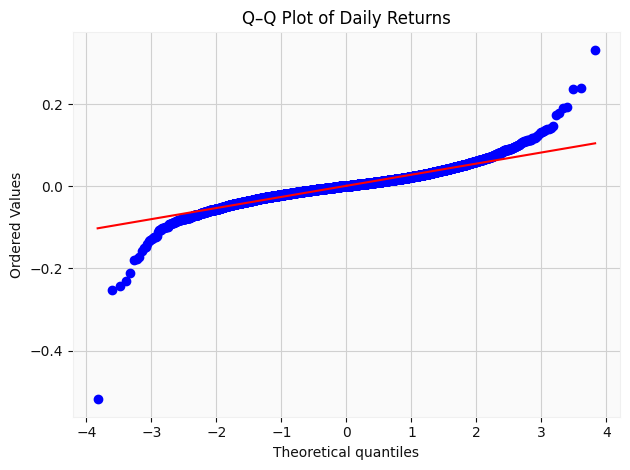

In [75]:
from scipy import stats
import matplotlib.pyplot as plt
stats.probplot(df["Daily Return"].dropna().values, dist="norm", plot=plt)
plt.title("Q–Q Plot of Daily Returns")
plt.tight_layout(); plt.show()


# Analysis report


### 1. Introduction

This analysis examines Apple’s stock performance between 1980 and 2023 using Python (Pandas, NumPy, and SciPy).<br>
The goal was to understand how the company’s stock evolved over time, analyze trends, and perform basic statistical tests, including a t-test and normality tests on daily returns.

### 2. Exploratory Data Analysis (EDA)


#### General Overview

- The dataset covers trading days from 1980 to 2023.

- Around 78.4% of the days are consecutive trading days, while the rest correspond to weekends or holidays — this is a normal pattern for stock market data.

- Each year has roughly 252 trading days, except 2023, which ends on 2023-01-27 (≈18 trading days).

#### Historical Phases of Apple Stock

1980–2000: Little to no growth in stock prices.

2000–2008: Modest growth as Apple re-established itself under Steve Jobs (first iPod release), followed by the 2008 financial crisis.

2008–2019: Exponential increase driven by major product launches like the iPhone and the rise of Apple’s brand loyalty.

2019–2021: Huge spike due to COVID-19 and global demand for electronics.

2022–2023: Sharp decline linked to the global supply chain crisis and overall tech market slowdown.

#### Price and Volume Behavior

- Apple’s closing price stayed relatively flat until the mid-2000s, then grew sharply.

- Trading volume (number of shares traded) increased significantly over time, showing growing investor interest.
Spikes in volume correspond to major economic or company events (e.g., 2008 crisis, major product launches, COVID-19).

- Between 2018–2022, both price and volume reached record highs — Apple became one of the most traded and valuable companies in the world.

| Variable       | Mean   | Median | Std   | Observation |
|----------------|--------|---------|-------|--------------|
| Price (Close)  | ~16–17 | ~0.5    | ~35   | Highly skewed distribution with large variability |
| Volume         | ~328M  | ~215M   | ~338M | Large daily variation in trading activity |


- The large difference between mean and median shows that prices are heavily skewed, likely due to stock splits and long-term growth.

- The standard deviation being higher than the mean confirms very high variability in Apple’s stock prices.

### 3. Trend Analysis

Visual inspection of prices shows:

2015–2018: Relatively flat movement, prices mostly between $20–$60.

2019–2020: Beginning of a strong uptrend, breaking above $60.

2020–2021: Rapid rise from $60 to above $180 due to strong earnings, iPhone 12 release, and COVID-related demand.

2022–2023: Decline from $180 to around $140–150 as inflation and global uncertainty hit the tech sector.

### 4. Hypothesis Testing (T-Test on Closing Prices)

To test if the average daily closing prices differed significantly between 2019 and 2020, a Welch’s two-sample t-test was performed (does not assume equal variances).

| Year | Mean Close | Std | N (days) |
|------|-------------|-----|-----------|
| 2019 | 52.06 | 8.63 | 252 |
| 2020 | 95.35 | 21.81 | 253 |


Results:

t = -29.34, p = 6.64×10⁻⁹⁴

Cohen’s d = - 2.61 (very large effect size)

Interpretation:
Because the p-value is far below 0.05, we reject the null hypothesis.
Average closing prices in 2020 were significantly higher than in 2019, and the large effect size shows this difference is not due to random fluctuations.

### 5. Normality Test of Daily Returns

Daily returns were calculated as the percentage change in closing price from one trading day to the next.

#### Distribution Summary

- The distribution is centered around 0, meaning most days Apple’s stock moved only slightly up or down.

- Typical daily movement was between -2% and +2%, with occasional extreme outliers (large jumps or drops).

Statistical Tests
| Test              | Statistic | p-value     | Interpretation |
|-------------------|------------|-------------|----------------|
| D’Agostino’s K²   | 2721.39    | < 1e-300    | Not normal     |
| Shapiro–Wilk      | 0.898      | 1.29×10⁻⁴⁹  | Not normal     |

Interpretation:
Both tests have p-values far below 0.05, so the null hypothesis of normality is rejected.
This confirms that Apple’s daily returns are not normally distributed — they are fat-tailed and asymmetric, which is common in financial markets where extreme movements occur more often than a normal curve predicts.

### 6. Overall Conclusion

- Apple’s stock shows distinct growth phases, with explosive increases after 2008 and especially around the COVID-19 period.

- Trading patterns are consistent with a real-world market: ~252 trading days per year and no activity on weekends/holidays.

- Prices and volumes have grown dramatically over time, with occasional sharp corrections during crises.

- The t-test showed a statistically significant and very large increase in average stock prices from 2019 to 2020.

- Normality tests revealed that daily returns are not normally distributed, reflecting the typical “fat-tailed” nature of financial data.